In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

![title](figs/COMPGEOP_TITLE.jpg)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from code_lib.quadrature import trapez_int,simpson_int,gauss_int

# Numerical Quadrature
Numerical quadrature, or numerical integration, is commonly used when the integrals are very difficult or even impossible to solve analytically. For example, one of the most commonly used function, the error function $erf(x) = \frac{2}{\pi}\int_0^x e^{t^2}dt$, has been proved to have no analytical form of solution. We need methods from numerical analysis to evaluate such integrals. 

We also need the algorithms when the integrand of the integral to be evaluated does not have an analytical form. For example, we may need to calculate the volume of a reservoir from seismic horizons, or to obtain accumulative production volume of a well from daily production rate measurement. 

In general, numeric integration means the numeric evaluation of integrals
$$
J = \int_a^b f(x)dx
$$
where $a$ and $b$ are given and $f$ is a function given analytically by a formula or empirically by a table of values. 
Geometrically, $J$ is the area under the curve of $f$ between $a$ and $b$. 

<img src="files/figs/figure440.png" width="300">

## Rectangular Rule
Rectangular rule is the simplest way to perform the numerical integration. It requires subdividing the interval of integration $a\leq x \leq b$ into $n$ subintervals of equal length $h=(b-a)/n$, and in each subinterval approximate $f$ by the constant $f(x^*_j)$, which is the value of $f$ at the midpoint $x_j^*$ of the $j$th subinterval. 
In this way, $f$ is approximated by a **step function** (piecewise constant function), and the $n$ rectangles have the areas $f(x_j^*)h$. The rectangular rule can be presented as:
$$
J = \int_a^b f(x)dx \approx h \sum_{i=1}^{n} f(x_i^*) 
$$
where $x_i^* = a + (i-1/2)h$.


<img src="files/figs/figure441.png" width="400">

### Python example of rectangular rule
Let's calculate a simple integration using rectangular rule:
$$\int_{-1}^1 (1-x^2) dx .$$
As we already know, this integral has the analytic solution as:
$$
\int_{-1}^1 (1-x^2) dx =
\left. x-\frac{x^3}{3} \right|_{-1}^{+1} = \frac{4}{3}
$$


In [3]:
# define the function to perform rectangular integration
def rect_int(fun,a,b,N,isfigure=False):
    ''' Function to perform rectangular integration.
    usage: val = rect_int(fun,a,b,N,isfigure=False)
    input: 
        fun: function to be integrated
        a,b: integral interval
        N: number of subintervals 
        isfigure: plot the function and the mid points for demonstration
    written by Ge Jin, gjin@mines.edu, 06/2019
    '''
    h = (b-a)/N # calculate subinterval length
    xi = a+(np.arange(N)+0.5)*h # calculate the location of mid points
    yi = fun(xi) # evaluate mid point values
    val = np.sum(yi)*h # calculate the result
    if isfigure:
        x = np.linspace(a,b,100)
        y = fun(x)
        plt.plot(x,y,label='Integrand')
        plt.plot(xi,yi,'ro',label='Mid Points')
    return val

Numerical result:  1.3518518518518516
Error: -1.851852e-02


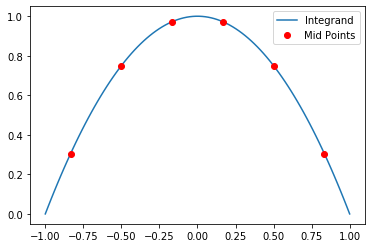

In [4]:
# define the integrand
fun = lambda x:1-x**2
# define integral inteval
a = -1; b = 1
# define subdivition number
N = 6
# print the result
result = rect_int(fun,a,b,N)
print('Numerical result: ',result)
print('Error: {:e}'.format(4/3-result))

# plot the function and the mid points
plt.figure()
rect_int(fun,a,b,N,isfigure=True)
plt.legend()
plt.show()

## Trapezoidal Rule
The trapezoidal rule is generally more accurate. It can be obtained by takin ghte same subdivision as the rectangular rule, and approximate $f$ by a piece-wise linear intepolation. The area under the curve of $f$ between $a$ and $b$ is approximated by $n$ trapezoids of areas
$$
\frac{1}{2}[f(a)+f(x_1)]h,
\frac{1}{2}[f(x_1)+f(x_2)]h,
\frac{1}{2}[f(x_2)+f(x_3)]h,
...,
\frac{1}{2}[f(x_{n-1})+f(x_b)]h,
$$
By taking hte sum we obtain the **trapezoidal rule**:
$$
J = \int_a^b f(x) dx \approx 
h \left[ \frac{1}{2} f(a) + f(x_1) + f(x_2) + ... + f(x_{n-1})+\frac{1}{2} f(b) \right],
$$
where $h=(b-a)/n$. The $x_j$, $a$, and $b$ are called **nodes**.

<img src="files/figs/figure442.png" width="400">

### Error analysis for trapezoidal rule
An error estimate for the trapezoidal rule can be derived from the error analysis of linear interpolation. For a single subinterval we have
$$
f(x)-p_i(x) = (x-x_i)(x-x_{i+1})\frac{f''(t)}{2}
$$
with a suitable (unknown) $t$ between $x_i$ and $x_{i+1}$. Integration over $x$ from $x_i$ to $x_{i+1} = x_i +h$ gives
$$
\int_{x_i}^{x_i+h} f(x) dx - \frac{h}{2} [f(x_i)+f(x_i+h)] = 
\int_{x_i}^{x_i+h} (x-x_i)(x-x_i-h)\frac{f''(t)}{2} dx.
$$
Setting $x-x_i = v$, we found the right side equals
$$
\int_0^h v(v-h) dv \frac{f''(t)}{2} = 
\left( \frac{h^3}{3} - \frac{h^3}{2}  \right) \frac{f''(t)}{2} = 
-\frac{h^3}{12} f''(t).
$$
This is the error for the $i$th subinterval for the trapezoidal rule, often called the **local error**. 

The error of the trapezoidal rule is the sum of such contributions from the $n$ subintervals. Since $h=(b-a)/n$, we obtain
$$
\epsilon = -\frac{(b-a)^3}{12n^2} f''(\hat{t}) = -\frac{b-a}{12}h^2 f''(\hat{t}).
$$
The trapezoidal rule is also written as:
$$
J = \int_a^b f(x) dx \approx 
h \left[ \frac{1}{2} f(a) + f(x_1) + f(x_2) + ... + f(x_{n-1})+\frac{1}{2} f(b) \right] 
-\frac{b-a}{12}h^2 f''(\hat{t}).
$$

Numerical result:  1.2962962962962963
Error: 3.703704e-02
Predicted Error: 3.703704e-02


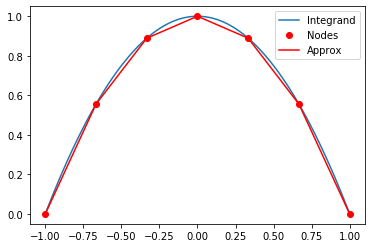

In [5]:
# define the integrand
fun = lambda x:1-x**2
# define integral inteval
a = -1; b = 1
# define subdivition number
N = 6
# print the result
result = trapez_int(fun,a,b,N)
print('Numerical result: ',result)
print('Error: {:e}'.format(4/3-result))

# in this case the error can be predicted, because f''(t) == -2
h = (b-a)/N
err = -(b-a)/12*h**2*(-2)
print('Predicted Error: {:e}'.format(err))

# plot the function and the mid points
plt.figure()
trapez_int(fun,a,b,N,isfigure=True)
plt.legend()
plt.show()

## Simpson's Rule

Rectangular rule and trapezoidal rule can be considered as piecewise zero-order (nearest) and first-order (linear) polynomial approximation of the integrand. **Simpson's Rule** utilizes the piecewise quadratic approximation, and is of great practical importance because it is sufficiently accurate for most problems, but still sufficiently simple.

To derive Simpson's rule, we divide the interval of integration $a\leq x \leq b$ into an **even number** of equal subintervals, say, into $n=2m$ subintervals of length $h = (b-a)/(2m)$, with endpoints $x_0(=a), x_1, ...,x_{2m-1},x_{2m}(=b)$. We now take the first two subintervals and approximate $f(x)$ in the interval $x_0 \leq x \leq x_2 = x_0 +2h$ by the Lagrange polynomial $p_2(x)$ through $(x_0,f_0), (x_1,f_1), (x_2,f_2)$, where $f_j=f(x_j)$. From Interpolation section we have
$$
p_2(x) = 
\frac{(x-x_1)(x-x_2)}{(x_0-x_1)(x_0-x_2)}f_0 +
\frac{(x-x_0)(x-x_2)}{(x_1-x_0)(x_1-x_2)}f_1 +
\frac{(x-x_0)(x-x_1)}{(x_2-x_0)(x_2-x_1)}f_2.
$$
With $x_1 = x_0 + h, x_2 = x_0 + 2h$, and setting $s = (x-x_1)/h$, we have 
$$
p_2(x) = 
\frac{1}{2} s(s-1) f_0 +
(s+1)(s-1) f_1 +
\frac{1}{2}(s+1)s f_2
$$
Now integrate with respect to $x$ from $x_0$ to $x_2$, which corresponds to integrating with respect to $s$ from -1 to 1, we have
$$
\int_{x_0}^{x_2} p_2(x)dx = 
f_0 \int_{-1}^{1} \frac{1}{2} s(s-1) hds +
f_1 \int_{-1}^{1} (s+1)(s-1) hds +
f_2 \int_{-1}^{1}  \frac{1}{2}(s+1)s hds \\
$$
The result is
$$
\int_{x_0}^{x_1} f(x) dx \approx 
\int_{x_0}^{x_1} p_2(x) dx =
h\left(
\frac{1}{3}f_0 +
\frac{4}{3}f_1 +
\frac{1}{3}f_2 \right)
$$
A similar formula holds for the next two subintervals from $x_2$ to $x_4$, and so on. By summing all these $m$ for formulas we obtain **Simpson's rule**
$$
\int_a^b f(x) dx \approx
\frac{h}{3} ( f_0 + 4f_1 + 2f_2 + 4f_3 + ... + 2f_{2m-2} + 4f_{2m-1} + f_{2m})
$$

<img src="files/figs/figure443.png" width="400">

### Error of Simpson's Rule
If the fourth derivative $f^{(4)}$ exists and is continuous on $a \leq x \leq b$, the error of Simpson's Rule is
$$
\epsilon_s = -\frac{(b-a)^5}{180(2m)^4} f^{(4)}(\hat t) 
= -\frac{b-a}{180} h^4 f^{(4)}(\hat t),
$$
where $\hat t$ is a suitable unknown value between $a$ and $b$. With this we may also write Simpson's rule as
$$
\int_a^b f(x) dx \approx
\frac{h}{3} ( f_0 + 4f_1 + 2f_2 + 4f_3 + ... + 2f_{2m-2} + 4f_{2m-1} + f_{2m})
 -\frac{b-a}{180} h^4 f^{(4)}(\hat t),
$$
The proof of Simpson's Rule error estimate can be found [here](https://www.math.ucla.edu/~yanovsky/Teaching/Math151A/hw6/Numerical_Integration.pdf).

### Degree of Precision
Degree of precision (DP) of an integration formula is determined by the maximum degree of arbitrary polynomials for which the formula gives exact values of integrals over any intervals.
For the rectangular rule and trapezoidal rule, 
$$ DP=1 $$
For Simpson's rule, from error analysis, we can get
$$ DP=3 $$
because $f^{(4)}$ is identically zero for a cubic polynomial. This makes Simpson's rule sufficiently accurate for most practical problems and accounts for its popularity.

### Numeric Stability
Numeric stability with respect to rounding is another important property to evaluate numeric algorithms. For the sum of the roundoff errors $\epsilon_j$ of the $2m+1$ values $f_j$ we obtain, since $h = (b-a)/2m$,
$$
\frac{h}{3} ( \epsilon_0 + 4\epsilon_1 + 2\epsilon_2 + 4\epsilon_3 + ... + 2\epsilon_{2m-2} + 4\epsilon_{2m-1} + \epsilon_{2m})
\leq \frac{1}{3} \frac{b-a}{2m} 6mu
= (b-a)u
$$
where $u$ is the rounding unit ($u=0.5\times 10^{-6}$ if we round off to 6D). $6m$ is the summation of the coefficients of $f_j$. The error bound $(b-a)u$ is independent of $m$, so that it cannot increase with increasing $m$. This proves stability.

### Newton-Cotes Formulas
The rectangular, trapezoidal and Simpson's rules are all special **Newton-Cotes formulas**,that is, integration formulas in which $f(x)$ is interpolated at **equally spaced** nodes by a polynomial degree $n$ ($n=0$ for rectangular, $n=1$ for trapezoidal, $n=2$ for Simpson). 
$n=3$ and higher are used occasionally. From $n=8$ on, some of the coefficients become negative, so that a positive $f_j$ could make a negative contribution to an integral, which is absurd. 

Numerical result:  1.3333333333333333
Error: 0.000000e+00


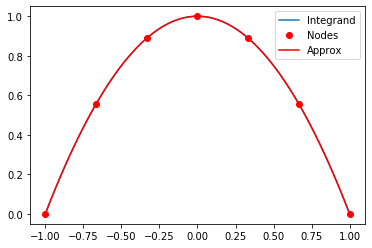

In [6]:
# define the integrand
fun = lambda x:1-x**2
# define integral inteval
a = -1; b = 1
# define subdivition number
N = 6
# print the result
result = simpson_int(fun,a,b,N)
print('Numerical result: ',result)
print('Error: {:e}'.format(4/3-result))

# plot the function and the mid points
plt.figure()
simpson_int(fun,a,b,N,isfigure=True)
plt.legend()
plt.show()

## Gauss Integration Formulas



All Newton-Cotes type of integrations can be written in a form of
$$
\int_a^b f(x)dx \approx \sum_{j=1}^{n} A_j f(x_j),
$$
where $f_j$ is the value of integrand at an evenly spaced grid $x_0,x_1,..x_n$. However, we can get much more accurate integration formulas if we allow $x_j$ to be arbitrarily located. 
With a fixed $n$, because we can freely determine the location of nodes $x_j$ and the weights $A_j$, there are $n+n=2n$ degrees of freedom. Theoretically, the coefficients of a polynomial of degree $2n-1$ can be uniquely determined.

Gauss has shown that exactness for polynomials of degree not exceeding $2n-1$ (instead of $n-1$ for predetermined nodes) can be attained. For a problem like
$$
\int_{-1}^{1} f(t) dt \approx \sum_{j=1}^{n} A_j f(t_j),
$$
he as given the location of the location of the $t_j$ and the coefficients $A_j$ which depend on $n$ but not on $f(t)$. The actual process to derive $t_j$ and $A_j$ is fairly complex and is not covered by this class, but can be found [here](https://en.wikipedia.org/wiki/Gaussian_quadrature#Fundamental_theorem). 

To calculate the numeric integral of $f$ of an arbitrary interval between $a$ and $b$, we can simply set 
$$x = \frac{b-a}{2}t+\frac{a+b}{2}$$
so that
$$
\int_a^b f(x) dx  = \int_{-1}^1 f\left(\frac{b-a}{2}t+\frac{a+b}{2}\right) \frac{b-a}{2} dt
\approx \frac{b-a}{2} \sum_{i=1}^{n} A_i f\left(\frac{b-a}{2}t_i+\frac{a+b}{2}\right)
$$

Here is a table of $t_j$ and $A_j$ for the first few $n$ and the python package to obtain them.

In [7]:
df = pd.DataFrame()
row_i = 0
for n in range(2,6):
    # numpy package to calculate gauss nodes and coefficient
    t, A = np.polynomial.legendre.leggauss(n)  
    for i in range(n):
        df.loc[row_i,'$n$'] = n
        df.loc[row_i,'Nodes $t_j$'] = t[i]
        df.loc[row_i,'Coefficients $A_j$'] = A[i]
        df.loc[row_i,' '] = ' '
        df.loc[row_i,'Degree of Precision'] = 2*n-1
        row_i += 1

df['$n$'] = df['$n$'].astype('int')
df['Degree of Precision'] = df['Degree of Precision'].astype('int')
df.set_index(['$n$','Degree of Precision',' '])

Nodes $t_j$  Coefficients $A_j$
$n$ Degree of Precision                                   
2   3                        -0.577350            1.000000
                              0.577350            1.000000
3   5                        -0.774597            0.555556
                              0.000000            0.888889
                              0.774597            0.555556
4   7                        -0.861136            0.347855
                             -0.339981            0.652145
                              0.339981            0.652145
                              0.861136            0.347855
5   9                        -0.906180            0.236927
                             -0.538469            0.478629
                              0.000000            0.568889
                              0.538469            0.478629
                              0.906180            0.236927

Numerical result:  1.3333333333333341
Error: -8.881784e-16


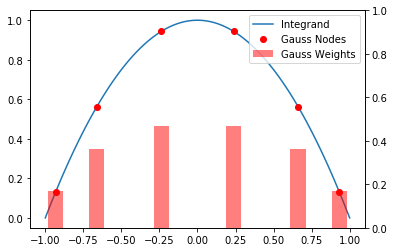

In [8]:
# define the integrand
fun = lambda x:1-x**2
# define integral inteval
a = -1; b = 1
# define subdivition number
N = 6
# print the result
result = gauss_int(fun,a,b,N)
print('Numerical result: ',result)
print('Error: {:e}'.format(4/3-result))

# plot the function and the mid points
plt.figure()
gauss_int(fun,a,b,N,isfigure=True)
plt.show()

### [Trapezoidal Rule in 2D](https://www.kth.se/social/upload/52a04c17f27654620e188bb0/Ant-Integration.pdf)
We consider double integrals
$$ I = \iint_\Omega f(x,y) dx dy $$
where $\Omega$ is a domain between two function graphs
$$
\Omega = \{(x,y) \in \mathbb{R}^2 : a \leq x \leq b, r(x) \leq y \leq s(x) \}
$$
In these cases the integral can be written in iterated form as
$$
I = \int_a^b \left(
\int_{r(x)}^{s(x)} f(x,y) dy \right) dx
=\int_a^b F(x) dx
$$
Numerically we can then do the same thing. The inner integral is approximated by a one-dimensional quadrature rule where $x$ is held fixed. The values obtained are then used to approximate the outer integral, also by a one-dimensional rule. 
$$
I \approx h \left(
\frac{1}{2} F(x_0) + F(x_1) + ... + F(x_{n-1}) + \frac{1}{2} F(x_n) 
\right)
$$
where $x_j = a+jh$ and $h = (b-a)/n$. In order to computer $F(x_j)$ we approximate again,
$$
F(x_j) = \int_{r(x_j)}^{s(x_j)} f(x_j,y)dy \approx h_j
\left(
\frac{1}{2} f(x_j,y_{j,0}) + f(x_j,y_{j,1}) + ... + f(x_j,y_{j,n-1}) + \frac{1}{2} f(x_j,y_{j,n})
\right),
$$
where 
$$ y_{j,k} = r(x_j) + kh_j, \ \ \  h_j = \frac{s(x_j)-r(x_j)}{n_j} $$
Note that in general the number of points in the $y$-direction, $n_j$, is different for different $x_j$. The choice of $n_j$ is usually taken such that $h\approx h_j$ for all $j$. 

The total formula becomes
$$
I \approx \sum_{j=0}^{n} \sum_{k=0}{n_j} w_{j,k} f(x_j,y_{j,k}) h h_j,
$$
where $w_{j,k}$ is 1 for points in the interior (open circles), $1/2$ along the outer edges (filled circles) and $1/4$ in the corner points (filled squares). 

#<img src="files/figs/2D_Trapezoidal.png" width="400">

### 2D Gaussian Quadrature

We can easily extend the formulas of 1D Gaussian quadrature into 2D by:
$$
\int_{-1}^1 \int_{-1}^1 f(\xi,\eta) d\xi d\eta 
\approx \int_{-1}^1 \sum_{i=1}^{N} w_i f(\xi_i,\eta) d\eta
\approx \sum_{j=1}^M \sum_{i=1}^{N} w_i \hat w_j f(\xi_i,\eta_j) 
$$
where $w_i$ and $\xi_i$ are the weights and nodes of Gaussian Quadrature of order N in $\xi$ direction, and $\hat w_i$ and $\eta_i$ are the weights and nodes of Gaussian Quadrature of order M in $\eta$ direction. If $M==N$, the formula can be simplied as
$$
\int_{-1}^1 \int_{-1}^1 f(\xi,\eta) d\xi d\eta 
\approx \sum_{j=1}^M \sum_{i=1}^{N} w_i w_j f(\xi_i,\xi_j) 
$$

<img src="files/figs/2Dlinearmapping.png" width="800">
We can then generalize this integral of a unit square to any quadrilateral shapes by conduction a linear mapping.
The mapping can be achieved by
$$
x = P(\xi,\eta) = \sum_{i=1}^4 x_i N_i(\xi,\eta) \\
y = P(\xi,\eta) = \sum_{i=1}^4 x_i N_i(\xi,\eta)
$$
where $N_i$ are nodal shape functions for quadrilaterals:
$$
N_1(\xi, \eta) = \frac{1}{4} (1-\xi)(1-\eta), \\
N_2(\xi, \eta) = \frac{1}{4} (1+\xi)(1-\eta), \\
N_3(\xi, \eta) = \frac{1}{4} (1+\xi)(1+\eta), \\
N_4(\xi, \eta) = \frac{1}{4} (1-\xi)(1+\eta).
$$
Note $N_i(\xi,\eta)=1$ at Node $i$th, 0 at other nodes.

Then we have
$$
\iint_K f(x,y)dx dy \approx
\sum_{i=1}^{N} \sum_{j=1}^{N} w_i w_j f\left(P(\xi_i,\xi_j),Q(\xi_i,\xi_j)\right) |J(\xi_i,\xi_j)|,
$$
where $J(\xi,\eta)$ is the Jacobi matrix
$$
J(\xi,\eta) = \left| \frac{\partial(x,y)}{\partial(\xi,\eta)} \right|
= \left| 
\begin{matrix} 
\frac{\partial x}{\partial \xi} & \frac{\partial y}{\partial \xi} \\
\frac{\partial x}{\partial \eta} & \frac{\partial y}{\partial \eta} 
\end{matrix}
\right|.
$$

## Python package to perform numeric integration
[Scipy](https://docs.scipy.org/doc/scipy/reference/) has a nice selection of [functions](https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html) to perform numeric integration with high precision and efficiency. 
Here I show two examples.

In [9]:
# if you know the function form
from scipy.integrate import quad
fun = lambda x:1-x**2
# define integral inteval
a = -1; b = 1
quad(fun,a,b)

(1.3333333333333335, 1.4802973661668755e-14)

In [10]:
# if you have a table of values
from scipy.integrate import simps
fun = lambda x:1-x**2
# define integral inteval
a = -1; b = 1
N = 6
xi = np.linspace(a,b,N+1)
yi = fun(xi)
simps(yi,xi)

1.3333333333333335

# Acknowledgement

Most of this teaching material is based on:

Kreyszig, E., 2018. Advanced Engineering Mathematics, 10-th edition.